In [1252]:
using Pkg
if !haskey(Pkg.installed(), "Images") || !haskey(Pkg.installed(), "ImageMagick") || !haskey(Pkg.installed(), "FileIO") || !haskey(Pkg.installed(), "Glob")
    println("Installing required packages...")
    Pkg.add.(["Images", "ImageMagick", "FileIO", "Glob"])
end



using LinearAlgebra
using GenericLinearAlgebra
using Images
using FileIO
using Glob
using ImageMagick  # pode ser necessário para JPEG


┌ Warning: Pkg.installed() is deprecated
└ @ Pkg C:\Users\mathe\.julia\juliaup\julia-1.10.2+0.x64.w64.mingw32\share\julia\stdlib\v1.10\Pkg\src\Pkg.jl:744
┌ Warning: Pkg.installed() is deprecated
└ @ Pkg C:\Users\mathe\.julia\juliaup\julia-1.10.2+0.x64.w64.mingw32\share\julia\stdlib\v1.10\Pkg\src\Pkg.jl:744
┌ Warning: Pkg.installed() is deprecated
└ @ Pkg C:\Users\mathe\.julia\juliaup\julia-1.10.2+0.x64.w64.mingw32\share\julia\stdlib\v1.10\Pkg\src\Pkg.jl:744
┌ Warning: Pkg.installed() is deprecated
└ @ Pkg C:\Users\mathe\.julia\juliaup\julia-1.10.2+0.x64.w64.mingw32\share\julia\stdlib\v1.10\Pkg\src\Pkg.jl:744


##  Objetivo

Dado uma **matriz unitária ou ortogonal** $A \in \mathbb{R}^{(m+n) \times (p+q)}$, queremos fazer a **CS decomposition**:

$$
A = 
\begin{bmatrix}
U_1 & 0 \\
0 & U_2
\end{bmatrix}
\begin{bmatrix}
C & -S & 0 \\
S & C & 0 \\
0 & 0 & I
\end{bmatrix}
\begin{bmatrix}
V_1^\top & 0 \\
0 & V_2^\top
\end{bmatrix}
$$

Esse é o caso mais geral (com bloco identidade no final se sobrarem dimensões), mas vamos focar no **caso simples** para clareza:

### Suponha:

$$
A \in \mathbb{R}^{(m + n) \times r},\quad \text{com } m = n = r
\Rightarrow A \in \mathbb{R}^{2r \times r}
$$

E seja:

$$
A = \begin{bmatrix}
A_1 \\
A_2
\end{bmatrix},\quad A_1, A_2 \in \mathbb{R}^{r \times r}
$$




## Passo a passo da CSD via SVD


### - **Passo 1: Obter os subespaços**

Seja:

* $A_1 \in \mathbb{R}^{r \times r}$
* $A_2 \in \mathbb{R}^{r \times r}$

Você quer decompor $A$ entendendo a **relação geométrica entre os subespaços linha** de $A_1$ e $A_2$.



### - **Passo 2: Aplicar SVD em $A_1$**

Faça:

$$
A_1 = U_1 \Sigma_1 V^\top
$$

* $U_1 \in \mathbb{R}^{r \times r}$ (ortogonal)
* $\Sigma_1 = \text{diag}(\sigma_1^{(1)}, \dots, \sigma_r^{(1)})$
* $V \in \mathbb{R}^{r \times r}$ (ortogonal)


### - **Passo 3: Aplicar SVD em $A_2$** usando **mesmo $V$**

Agora, defina:

$$
\tilde{A}_2 = A_2 V
$$

E aplique SVD em $\tilde{A}_2$:

$$
\tilde{A}_2 = U_2 \Sigma_2
$$

Você agora tem:

* $A_1 = U_1 \Sigma_1 V^\top$
* $A_2 = U_2 \Sigma_2 V^\top$

Essas decomposições **compartilham a mesma base $V$** (isso é importante e possível porque $A$ é unitária).



### - **Passo 4: Obter os ângulos principais**

Agora, queremos achar os ângulos $\theta_i$ tais que:

$$
\cos(\theta_i) = \sigma_i^{(1)}, \quad \sin(\theta_i) = \sigma_i^{(2)}
$$

Como $A$ é unitária:

$$
A_1^\top A_1 + A_2^\top A_2 = I
\Rightarrow \Sigma_1^2 + \Sigma_2^2 = I
$$

Portanto, podemos definir:

$$
\theta_i = \arccos(\sigma_i^{(1)}) = \arcsin(\sigma_i^{(2)})
$$





### - **Passo 5: Construir os blocos da CSD**

* $C = \mathrm{diag}(\cos(\theta_1), \dots, \cos(\theta_r))$
* $S = \mathrm{diag}(\sin(\theta_1), \dots, \sin(\theta_r))$

A matriz do meio da CSD será:

$$
\begin{bmatrix}
C & -S \\
S & C
\end{bmatrix}
$$

E a CSD completa é:

$$
A = 
\begin{bmatrix}
U_1 & 0 \\
0 & U_2
\end{bmatrix}
\begin{bmatrix}
C & -S \\
S & C
\end{bmatrix}
V^\top
$$



##  Recapitulando (Fluxo)

1. **Particione** $A$ em $A_1$ e $A_2$
2. **SVD** de $A_1 = U_1 \Sigma_1 V^\top$
3. Defina $\tilde{A}_2 = A_2 V$, depois faça $\tilde{A}_2 = U_2 \Sigma_2$
4. Calcule $\theta_i = \arccos(\sigma_i^{(1)})$
5. Monte $C, S$, e a decomposição completa



###  Observação importante

Esse processo depende de $A$ ser **unitária/ortogonal** — ou seja, $A^\top A = I$. Caso contrário, essa relação $\Sigma_1^2 + \Sigma_2^2 = I$ **não se sustentaria**, e os cossenos e senos não formariam uma matriz de rotação.



In [1253]:
function build_csd_input_matrix(D1::Matrix{Float64}, D2::Matrix{Float64})
    # D1: m × d (m amostras, d features) - dataset 1
    # D2: n × d (n amostras, d features) - dataset 2

    # Passo 1: QR dos transpostos (colunas de D1 e D2 como vetores base)
    Q1, R1 = qr(D1')  
    Q2, R2 = qr(D2') 
    
    
    if size(R1, 1) == size(R1, 2)
        m= size(Q1, 1)
        n = size(R1, 2)
        R1_full = zeros(m, n)
        R1_full[1:n, :] = R1
    else
        R1_full = R1
    end
    if size(R2, 1) == size(R2, 2)
        m= size(Q2, 1)
        n = size(R2, 2)
        R2_full = zeros(m, n)
        R2_full[1:n, :] = R2      
    else
        R2_full = R2  
    end
    
    # Passo 2: Ortonormaliza a união dos subespaços de Q1 e Q2
    Q_all, _ = qr(hcat(Matrix(Q1), Matrix(Q2)))  # Q_all ∈ ℝ^{d × r}, com r ≤ m + n
    
    # Passo 3: Projeta Q1 e Q2 no subespaço comum Q_all
    
    A1 = Q_all' * Matrix(Q1)
    A2 = Q_all' * Matrix(Q2)
     
    # Passo 4: Constrói a matriz A com blocos
    top = hcat(A1, zeros(size(A1, 1), size(A2, 2)))    # [A1  0]
    bottom = hcat(zeros(size(A2, 1), size(A1, 2)), A2)  # [0   A2]
    A = vcat(top, bottom)  # ∈ ℝ^{2r × (m + n)}

    return A, Matrix(Q_all), R1_full, R2_full
end

build_csd_input_matrix (generic function with 1 method)

In [1254]:
function rebuild_datasets_matrices(A, Q_all, R1, R2)
    # A: matriz de entrada
    # Q_all: base ortonormal comum
    # R1: matriz triangular superior de D1
    # R2: matriz triangular superior de D2

    r = size(Q_all, 2)  # dimensão do subespaço comum

    A1 = A[1:r, 1:size(R1, 1)] 
    D1_reconstructed = (Q_all * (pinv(A1') * R1))'

    A2 = A[r+1:end, end-size(R2,1)+1:end] 
    D2_reconstructed = (Q_all * (pinv(A2')* R2))'
    
    # D1_reconstructed: matriz reconstruída de D1
    # D2_reconstructed: matriz reconstruída de D2

    # Retorna as matrizes reconstruídas
    return D1_reconstructed, D2_reconstructed
    
end

rebuild_datasets_matrices (generic function with 1 method)

In [1255]:
# Exemplo com dados aleatórios
m = 5  # amostras de D1
n = 7  # amostras de D2
d = 6  # número de features

D1 = randn(m, d)  # dataset 1
D2 = randn(n, d)  # dataset 2

A, Q_all, R1, R2 = build_csd_input_matrix(D1, D2)

([1.0 0.0 … 0.0 0.0; 1.3877787807814457e-16 0.9999999999999998 … 0.0 0.0; … ; 0.0 0.0 … 0.24085907695900352 0.035976206833784; 0.0 0.0 … -0.3347298118780156 0.5102532038794794], [-0.39868529816769893 -0.5812852234327539 … 0.009937079234997537 -0.5043391089404753; -0.21626702159454003 -0.46469306130033594 … -0.478053844482277 0.5566578297157637; … ; 0.38260003274669796 0.12529948672217478 … -0.6844299622698524 -0.546957666558141; 0.020362238495183545 -0.04162175897950438 … -0.4947574831877297 0.218631798996612], [-2.970862580111601 -0.667996755588848 … -1.1802408684410368 1.2009232908770615; 0.0 2.322046555045179 … -0.568782798804057 0.6265306767542711; … ; 0.0 0.0 … 0.0 -1.1207260556263738; 0.0 0.0 … 0.0 0.0], [0.8623895159239636 -0.23090182085048216 … 0.3392224610767932 -0.9929818442402855; 0.0 2.6459526341295914 … 0.9989732117226797 -0.5953733312031306; … ; 0.0 0.0 … 0.7017422375259853 -1.4107256179419942; 0.0 0.0 … 0.42954620243573094 1.5219231415997254])

In [1256]:
function verify_A(A::Matrix{Float64})
    if A'*A ≈ I
        println("A matriz A é ortonormal")
    else
        println("A matriz A não é ortonormal")
        
    end
end

verify_A (generic function with 2 methods)

In [1257]:
# Exibir e verificar a corretude da matriz A
display(A)
verify_A(A)
D1_reconstructed, D2_reconstructed = rebuild_datasets_matrices(A, Q_all, R1, R2)

    if D1_reconstructed ≈ D1 && D2_reconstructed ≈ D2
        println("As matrizes reconstruídas são equivalentes às originais!")
    else
        println("As matrizes reconstruídas NÃO são equivalentes às originais.")
        
    end

12×11 Matrix{Float64}:
  1.0           0.0          …   0.0         0.0         0.0
  1.38778e-16   1.0              0.0         0.0         0.0
 -5.55112e-17   0.0              0.0         0.0         0.0
  0.0           2.77556e-17      0.0         0.0         0.0
 -1.11022e-16  -1.38778e-16      0.0         0.0         0.0
  5.55112e-17   3.46945e-17  …   0.0         0.0         0.0
  0.0           0.0             -0.412899    0.142534   -0.654765
  0.0           0.0             -0.760901   -0.0172653   0.44122
  0.0           0.0             -0.0745196  -0.145776    0.121932
  0.0           0.0              0.0381173  -0.887738   -0.316367
  0.0           0.0          …   0.474352    0.240859    0.0359762
  0.0           0.0              0.136116   -0.33473     0.510253

A matriz A é ortonormal
As matrizes reconstruídas são equivalentes às originais!


In [1258]:
function load_images_as_dataset(folder_path::String)
    # Lista todos os arquivos JPEG na pasta
    image_paths = Glob.glob("*.jpg", folder_path)
    num_images = length(image_paths)

    if num_images == 0
        error("Nenhuma imagem encontrada na pasta.")
    end

    # Carrega uma imagem para obter dimensões
    img_sample = load(image_paths[1])
    img_rgb = convert(Array{RGB{N0f8}}, img_sample)
    h, w = size(img_rgb)[1:2]

    println("Dimensões da imagem: $h x $w")

    # Inicializa matriz dataset
    dataset = zeros(Float64, num_images, h * w * 3)

    for (i, path) in enumerate(image_paths)
        img = load(path)
        img_rgb = convert(Array{RGB{N0f8}}, img)
        r = Float64.(channelview(img_rgb)[1, :, :])
        g = Float64.(channelview(img_rgb)[2, :, :])
        b = Float64.(channelview(img_rgb)[3, :, :])
        dataset[i, :] = vcat(vec(r), vec(g), vec(b))
    end

    return dataset, h, w
end


load_images_as_dataset (generic function with 1 method)

In [1259]:
function reconstruct_image_from_vector(X::Matrix{Float64}, h::Int, w::Int, img_num::Int)
    vec_img = X[img_num, :]
    n_pixels = h * w

    r = reshape(vec_img[1:n_pixels], h, w)
    g = reshape(vec_img[n_pixels+1:2*n_pixels], h, w)
    b = reshape(vec_img[2*n_pixels+1:3*n_pixels], h, w)

    img_rgb = colorview(RGB, r, g, b)
    return img_rgb
end

reconstruct_image_from_vector (generic function with 2 methods)

In [1260]:
#"D:\Docs matheus\UFRJ\7-Setimo Periodo\Alg. Lininear Aplicada\Trabalho final\Dataset PlayingCards\train\(card name)"

folder = raw"D:\Docs matheus\UFRJ\7-Setimo Periodo\Alg. Lininear Aplicada\Trabalho final\Dataset PlayingCards\train\jack of hearts"
X, h, w = load_images_as_dataset(folder)
size(X) 

Dimensões da imagem: 224 x 224


(168, 150528)

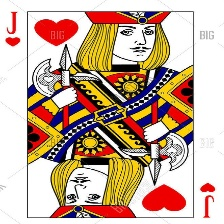

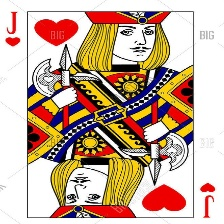

In [1261]:
num = 3  # Número da imagem que você quer reconstruir
#se o folder contém "train", usa o formato com zeros à esquerda
#se não (se for "test"), usa o formato sem zeros à esquerda
img_path = occursin("train", folder) ? (folder * "\\" * lpad(string(num), 3, "0") * ".jpg") : (folder * "\\" * string(num) * ".jpg") 
img9 = load(img_path)
display(img9)

img9_reconstruct= reconstruct_image_from_vector(X, h, w, num)
display(img9_reconstruct)

In [1262]:
function display_image_grid(X::Matrix{Float64}, img_size::Tuple{Int,Int}, indices::Vector{Int}; grid_shape::Tuple{Int,Int}=nothing)
    n_imgs = length(indices)
    h, w = img_size

    # Define grid shape if not provided
    if grid_shape === nothing
        ncols = ceil(Int, sqrt(n_imgs))
        nrows = ceil(Int, n_imgs / ncols)
    else
        nrows, ncols = grid_shape
    end

    # Create empty canvas for each channel
    grid_r = zeros(Float64, nrows*h, ncols*w)
    grid_g = zeros(Float64, nrows*h, ncols*w)
    grid_b = zeros(Float64, nrows*h, ncols*w)

    n_pixels = h * w

    for (k, idx) in enumerate(indices)
        row = div(k-1, ncols)
        col = mod(k-1, ncols)
        img_vec = X[idx, :]
        r = reshape(img_vec[1:n_pixels], h, w)
        g = reshape(img_vec[n_pixels+1:2*n_pixels], h, w)
        b = reshape(img_vec[2*n_pixels+1:3*n_pixels], h, w)
        grid_r[(row*h+1):(row+1)*h, (col*w+1):(col+1)*w] .= r
        grid_g[(row*h+1):(row+1)*h, (col*w+1):(col+1)*w] .= g
        grid_b[(row*h+1):(row+1)*h, (col*w+1):(col+1)*w] .= b
    end

    display(colorview(RGB, grid_r, grid_g, grid_b))
end


display_image_grid (generic function with 1 method)

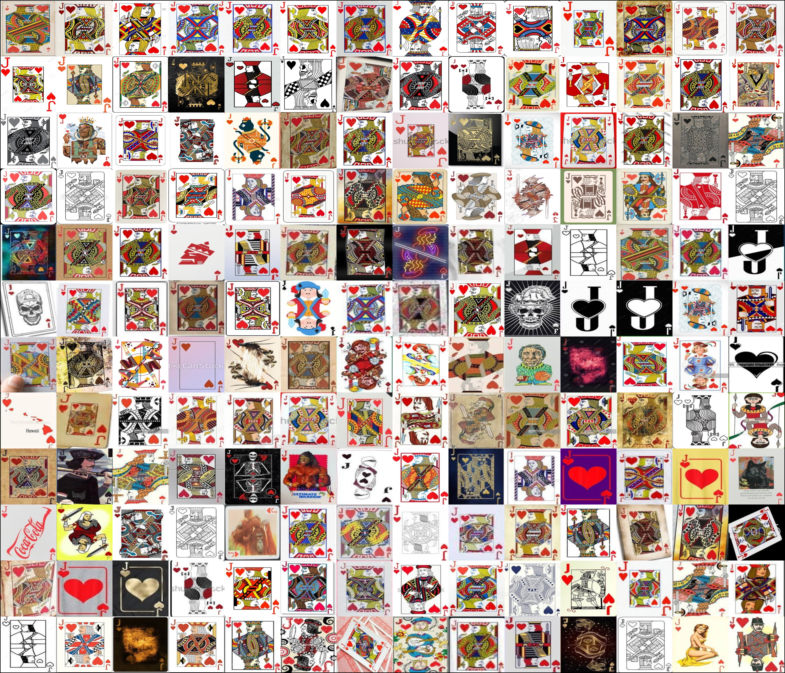

Número de imagens no dataset: 168
Número de linhas do grid: 12
Número de colunas do grid: 14


In [1263]:
function best_grid_shape(n_imgs::Int)
    # Procura divisores de n_imgs para formar um grid mais "quadrado" possível
    best_rows, best_cols = 1, n_imgs
    min_diff = n_imgs
    for rows in 1:floor(Int, sqrt(n_imgs))
        if n_imgs % rows == 0
            cols = div(n_imgs, rows)
            if abs(rows - cols) < min_diff
                best_rows, best_cols = rows, cols
                min_diff = abs(rows - cols)
            end
        end
    end
    # Se n_imgs é primo, usa aproximação quadrada
    if (best_rows == 1 || abs(best_rows - best_cols) > min(best_rows, best_cols)) && n_imgs > 10
        best_rows = floor(Int, sqrt(n_imgs))
        best_cols = ceil(Int, n_imgs / best_rows)
    end
    return best_rows, best_cols
end


size_dataset = size(X, 1)
grid_rows, grid_cols = best_grid_shape(size_dataset)
println("Número de imagens no dataset: ", size_dataset)
println("Número de linhas do grid: ", grid_rows)
println("Número de colunas do grid: ", grid_cols)
display_image_grid(X, (h, w), collect(1:size_dataset); grid_shape=(grid_rows, grid_cols))

In [1264]:
folder = raw"D:\Docs matheus\UFRJ\7-Setimo Periodo\Alg. Lininear Aplicada\Trabalho final\Dataset PlayingCards\train\ace of clubs"
Y, h, w = load_images_as_dataset(folder)
size(Y) 

Dimensões da imagem: 224 x 224


(120, 150528)

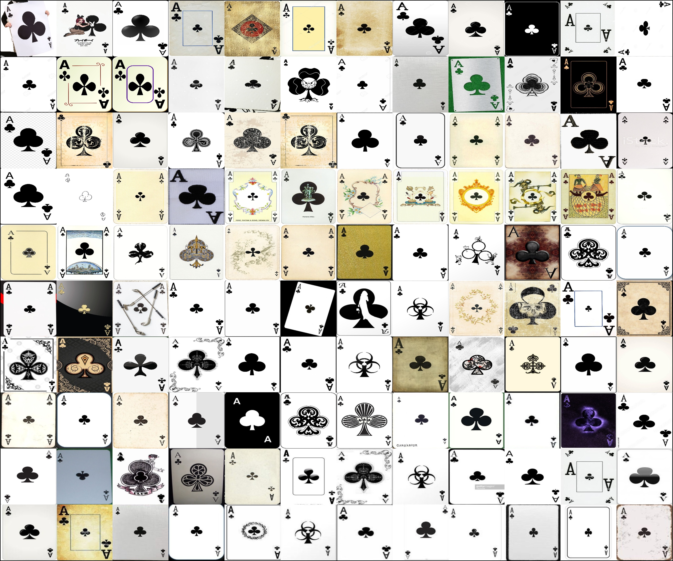

Número de imagens no dataset: 120
Número de linhas do grid: 10
Número de colunas do grid: 12


In [1265]:

size_dataset = size(Y, 1)
grid_rows, grid_cols = best_grid_shape(size_dataset)
println("Número de imagens no dataset: ", size_dataset)
println("Número de linhas do grid: ", grid_rows)
println("Número de colunas do grid: ", grid_cols)
display_image_grid(Y, (h, w), collect(1:size_dataset); grid_shape=(grid_rows, grid_cols))

In [1266]:
A, Q_all, R1, R2 = build_csd_input_matrix(X, Y)

([1.0000000000000058 3.4531839193663316e-17 … 0.0 0.0; 8.977193988179977e-17 1.000000000000001 … 0.0 0.0; … ; 0.0 0.0 … -2.710505431213761e-18 -5.204170427930421e-18; 0.0 0.0 … -3.469446951953614e-18 -5.204170427930421e-18], [-0.003539301728416877 0.00020662997232347982 … 0.003231700203209082 -0.006013392568339295; -0.003664586745351963 -5.879379899331738e-5 … 0.0018741187985816846 -0.005225625512324701; … ; -0.0033670348301310772 0.0002854834998027967 … 0.0011919310721396124 -0.008304411283703128; -0.0034296773385986317 4.631425303592497e-5 … 0.0016993855352381913 -0.009144389427572118], [-250.40942474275815 -249.56306469732561 … -312.9886642153508 -265.0745612508744; 0.0 147.34795550490284 … 71.20351346805725 73.39313403786778; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [-328.5257890157911 -311.75226968818646 … -339.09430368178954 -304.8858902283752; 0.0 -146.8957910115841 … -101.82472376419138 -91.92789505641193; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0])

In [1267]:
# Exibir e verificar a corretude da matriz A
display(A)
verify_A(A)

301056×288 Matrix{Float64}:
  1.0           3.45318e-17   2.64545e-17  …   0.0           0.0
  8.97719e-17   1.0          -5.29904e-17      0.0           0.0
 -1.86483e-17  -2.3744e-17    1.0              0.0           0.0
  6.07153e-18   6.57298e-17  -9.75782e-19      0.0           0.0
 -2.55872e-17  -5.11201e-17   1.5233e-17       0.0           0.0
 -6.93889e-18   1.63715e-17  -1.89193e-17  …   0.0           0.0
 -2.12504e-17  -1.15196e-18  -2.4774e-17       0.0           0.0
  1.86483e-17   2.13046e-17   1.94614e-17      0.0           0.0
  1.69136e-17  -2.44217e-17  -2.59124e-17      0.0           0.0
 -1.86483e-17  -2.53432e-17   4.0766e-17       0.0           0.0
  ⋮                                        ⋱                
  0.0           0.0           0.0              1.95156e-18   5.96311e-19
  0.0           0.0           0.0              3.03577e-18  -8.67362e-19
  0.0           0.0           0.0              2.27682e-18  -2.60209e-18
  0.0           0.0           0.0         

A matriz A é ortonormal
